In [2]:
# import deeplabcut
import tensorflow as tf

import numpy as np
import pandas as pd

import json

from angle_out import out

# print("dlc",deeplabcut.__version__)
print("tf",tf.__version__)

2023-08-28 02:18:48.711457: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-28 02:18:48.832601: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-08-28 02:18:49.323013: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-12.0/lib64:/usr/local/cuda/extras/CUPTI/lib64:/home/dlc/miniconda3/envs/deeplabcut/lib/
2023-08-28 02:18:49.323059: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load d

tf 2.10.0


In [4]:
video_path = "./videos2/coco_train02.mov"
video_path = "/home/dlc/DLC/label/BODYLOWER/20201024_dog-bodylower-000061"
nparr = np.load(f"{video_path}.npy")

print(type(nparr))
print(nparr.shape)
print(nparr)

# 전체 키포인트(관절좌표)
keypoint = [
    "Left_Front_Paw",
    "Left_Front_Wrist",
    "Left_Front_Elbow",
    
    "Left_Back_Paw",
    "Left_Back_Wrist",
    "Left_Back_Elbow",
         
    "Right_Front_Paw",
    "Right_Front_Wrist",
    "Right_Front_Elbow",
    
    "Right_Back_Paw",
    "Right_Back_Wrist",
    "Right_Back_Elbow",
         
    "Tail_Set",
    "Tail_Tip",
    
    "Left_Base_Ear",
    "Right_Base_Ear",
    
    "Nose",
    "Chin",
    
    "Left_Tip_Ear",
    "Right_Tip_Ear",
    
    "Withers"]

# 각 연결된 키포인트에 대한 데이터
link_parts = [
    ["Left_Front_Paw","Left_Front_Wrist"],
    ["Left_Front_Wrist","Left_Front_Elbow"],
    
    ["Left_Back_Paw","Left_Back_Wrist"],
    ["Left_Back_Wrist","Left_Back_Elbow"],
    
    ["Right_Front_Paw","Right_Front_Wrist"],
    ["Right_Front_Wrist","Right_Front_Elbow"],
    
    ["Right_Back_Paw","Right_Back_Wrist"],
    ["Right_Back_Wrist","Right_Back_Elbow"],
    
    ["Tail_Set","Tail_Tip"],
    ["Withers","Tail_Set"],
    ["Nose","Withers"],
    ["Chin","Nose"],
    
    ["Nose","Left_Base_Ear"],
    ["Left_Base_Ear","Left_Tip_Ear"],
    
    ["Nose","Right_Base_Ear"],
    ["Right_Base_Ear","Right_Tip_Ear"],
    
    ["Withers","Left_Front_Elbow"],
    ["Withers","Right_Front_Elbow"],
    
    ["Tail_Set","Left_Back_Elbow"],
    ["Tail_Set","Right_Back_Elbow"]]

# 실제 학습할 때 사용할 관절좌표의 관계
label_parts = [
    ["Nose", "Withers", "Tail_Set", "Tail_Tip"],                              # 코 - 목 - 엉덩이 - 꼬리
    ["Withers", "Left_Front_Elbow", "Left_Front_Wrist", "Left_Front_Paw"],    # 목 - 왼쪽 앞다리
    ["Withers", "Right_Front_Elbow", "Right_Front_Wrist", "Right_Front_Paw"], # 목 - 오른쪽 앞다리
    ["Tail_Set", "Left_Back_Elbow", "Left_Back_Wrist", "Left_Back_Paw"],      # 엉덩이 - 왼쪽 뒷다리
    ["Tail_Set", "Right_Back_Elbow", "Right_Back_Wrist", "Right_Back_Paw"]    # 엉덩이 - 오른쪽 뒷다리
]

<class 'numpy.ndarray'>
(42, 10, 14)
[[[ -81.28842241  314.83310083   15.79054573 ...  189.76410811
    -69.22507368  163.43208137]
  [ 187.68518444 -149.97543629 -103.88442792 ...    0.
    119.50710615  120.90689785]
  [ -97.30043462  249.97555654 -262.94172217 ... -171.33345281
    143.53191412 -177.91296098]
  ...
  [  36.65601369 -186.1448161     0.75285415 ...  224.97015714
    145.89549853 -172.83054579]
  [  33.12823467 -160.6879805   158.22498446 ...   22.92211839
    153.3193181  -185.85634423]
  [ 202.73403349 -143.74209993  -97.63546323 ...    0.
    180.41516763 -171.18211362]]

 [[ -81.28842241  314.83310083   15.79054573 ...  189.76410811
    -69.22507368  163.43208137]
  [ 187.68518444 -149.97543629 -103.88442792 ...    0.
    119.50710615  120.90689785]
  [ -97.30043462  249.97555654 -262.94172217 ... -171.33345281
    143.53191412 -177.91296098]
  ...
  [  36.65601369 -186.1448161     0.75285415 ...  224.97015714
    145.89549853 -172.83054579]
  [  33.12823467 -160.6

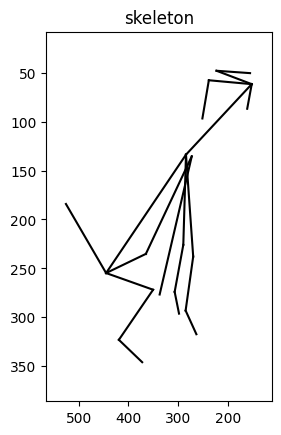

In [ ]:
import matplotlib.pyplot as plt 

def plot_line(a, b):
    # print(a,b)
    # 관절마다 선긋기
    # if (a.any()> 0 and b.any()>0): 
    plt.plot([a["x"], b["x"]], [a["y"], b["y"]], 'k-')
    
def draw_skeleton(sample):
    
    skeleton = sample
    
    # 각 신체부위의 xy좌표 추출
    Left_Front_Paw = skeleton["Left_Front_Paw"]
    Left_Front_Wrist = skeleton["Left_Front_Wrist"]
    Left_Front_Elbow = skeleton["Left_Front_Elbow"]    
    
    Left_Back_Paw = skeleton["Left_Back_Paw"]
    Left_Back_Wrist = skeleton["Left_Back_Wrist"]
    Left_Back_Elbow = skeleton["Left_Back_Elbow"]

    Right_Front_Paw = skeleton["Right_Front_Paw"]
    Right_Front_Wrist = skeleton["Right_Front_Wrist"]
    Right_Front_Elbow = skeleton["Right_Front_Elbow"]
    
    Right_Back_Paw = skeleton["Right_Back_Paw"]
    Right_Back_Wrist = skeleton["Right_Back_Wrist"]
    Right_Back_Elbow = skeleton["Right_Back_Elbow"]
    
    Tail_Set = skeleton["Tail_Set"]
    Tail_Tip = skeleton["Tail_Tip"]
    
    Left_Base_Ear = skeleton["Left_Base_Ear"]
    Right_Base_Ear = skeleton["Right_Base_Ear"]
    
    Nose = skeleton["Nose"]
    Chin = skeleton["Chin"]
    
    Left_Tip_Ear = skeleton["Left_Tip_Ear"]
    Right_Tip_Ear = skeleton["Right_Tip_Ear"]
    
    Withers = skeleton["Withers"]

    
    inbox={'facecolor':'w','edgecolor':'r','boxstyle':'round','alpha':0.5}
    outbox={'facecolor':'w','edgecolor':'b','boxstyle':'round','alpha':0.5}
    # 각 관절 점 및 텍스트 표시
    for part in sample.values():
        plt.plot(part["x"], part["y"])
        # plt.text(part["x"], part["y"], '.', verticalalignment='bottom' , horizontalalignment='center' )
    
    # 신체에 맞게 각 관절 선으로 연결
    for part in link_parts:
        plot_line(sample[part[0]], sample[part[1]])
    
def skeleton_plot(sample):
    # 그래프 padding 값
    pad_ori = 40
    plt.subplot(122)
    plt.title('skeleton')
    X_ori = sample
    # print(X_ori)
    
    # 관절의 최대 최소값을 구해 그래프 영역 설정
    # print(X_ori)
    x = []
    y = []
    for v in X_ori.values():
        # print(v["x"])
        x.append(v["x"])
        y.append(v["y"])
    
    x_max = max(x) + pad_ori
    x_min = min(x) - pad_ori
    y_max = max(y) + pad_ori
    y_min = min(y) - pad_ori

    plt.xlim(x_max, x_min)
    plt.ylim(y_max, y_min)
    draw_skeleton(X_ori)
    
pose_list = json.load(open(f"{video_path}.json","r"))
# print(pose_list)
for img, pose in pose_list.items():
    if img == f"{1}_img":
        # print(pose)
        skeleton_plot(pose)

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_validate, cross_val_score, cross_val_predict
from sklearn import model_selection

from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm, tree

def make_model(mod = "forest"):

    if mod == "svc":
        model = svm.SVC()
    elif mod == "tree":
        model = tree.DecisionTreeClassifier()
    elif mod == "forest":
        model = RandomForestClassifier()
    elif mod == "sgd":
        model = SGDClassifier()
    elif mod == "logistic":
        model = LogisticRegression()

    # print(model)

    return model

make_model()

RandomForestClassifier()

--- angle out test ---

In [10]:
json_path = "/home/dlc/DLC/_mina/data/AI-Hub/poseEstimation/Validation/DOG/labelFOOTUP/json/20201105_dog-footup-000611.mp4.json"
with open(json_path, "r", encoding="utf-8") as f:
    data = json.load(f)

# 선택한 키의 값만 추출
selected_data = []
for annotation in data["annotations"]:
    row = []
    for keypoint in annotation["keypoints"].values():
        if keypoint is not None:
            row.extend([int(keypoint["x"]), int(keypoint["y"])])
        else:
            row.extend([None, None])
    selected_data.append(row)

# # dict로 변환
# result = []
# for row in selected_data:
#     temp = []
#     for i in range(0, len(row), 2):
#         if row[i] is not None and row[i+1] is not None:
#             temp.append({"x": row[i], "y": row[i+1]})
#         else:
#             temp.append({"x": None, "y": None})
#     result.append(temp)


print(selected_data)
print(len(selected_data))

body_parts = [
    "Nose",
    "Forehead",
    "MouthCorner",
    "LowerLip",
    "Neck",
    "RightArm",
    "LeftArm",
    "RightWrist",
    "LeftWrist",
    "RightFemur",
    "LeftFemur",
    "RightAnkle",
    "LeftAnkle",
    "TailStart",
    "TailTip"
]
label_parts = [
    ["RightWrist", "RightArm", "Nose"],      # frontRightView 
    ["LeftWrist", "LeftArm", "Nose"],        # frontLeftView 
    ["TailTip", "RightFemur", "RightAnkle"],     # backRightView
    ["TailTip", "LeftFemur", "LeftAnkle"],        # backLeftView
    ["Neck", "RightWrist", "TailStart"],        # frontRightTilt
    ["Neck", "LeftWrist", "TailStart"],      # frontLeftTilt
    ["Neck", "TailStart", "RightAnkle"],     # backRightTilt
    ["Neck", "TailStart", "LeftAnkle"],       # backLeftTilt
    ["Neck", "RightArm", "RightWrist"],     # frontRight
    ["Neck", "LeftArm", "LeftWrist"],        # frontLeft
    ["TailStart", "RightFemur", "RightAnkle"],       # backRight
    ["TailStart", "LeftFemur", "LeftAnkle"],      # backLeft
    ["Nose", "Neck", "TailStart"],       # frontBody
    ["Neck", "TailStart", "TailTip"],     # backBody
]

label_parts = label_parts 
body_parts = body_parts * 84


out(np.array(selected_data), body_parts, label_parts=label_parts)

[[556, 934, 566, 719, 632, 924, 572, 975, 592, 571, 477, 977, 768, 922, 419, 855, 823, 1134, 464, 551, 856, 708, 426, 850, 859, 945, 607, 480, 891, 712], [486, 933, 493, 712, 557, 946, 506, 975, 558, 564, 433, 994, 724, 935, 388, 859, 764, 1148, 449, 537, 795, 711, 391, 862, 528, 1128, 616, 473, 754, 473], [443, 956, 451, 730, 513, 970, 463, 992, 532, 602, 417, 1019, 695, 986, 484, 1137, 709, 1163, 454, 563, 765, 737, 365, 916, 790, 988, 610, 484, 791, 484], [435, 971, 434, 757, 496, 985, 448, 1004, 537, 653, 422, 1044, 665, 993, 471, 1138, 674, 1185, 470, 610, 742, 683, 598, 1121, 460, 1121, 667, 506, 316, 575], [411, 956, 408, 741, 474, 954, 427, 992, 525, 656, 411, 1025, 657, 996, 333, 881, 631, 1185, 489, 609, 757, 697, 589, 1107, 759, 717, 688, 512, 731, 542], [399, 915, 401, 705, 438, 954, 409, 957, 523, 592, 413, 1010, 625, 955, 520, 1097, 611, 1176, 549, 535, 775, 680, 579, 1086, 798, 666, 722, 505, 539, 505], [346, 892, 351, 679, 385, 926, 359, 934, 471, 580, 388, 976, 601, 93

array([-219.47177452, -232.70182595, -196.41425483, -185.58567696,
       -134.04457303, -137.05354096, -123.57550885,  232.39277529,
        -57.5615739 ,  -40.12390735, -200.63774428, -200.06776921,
       -203.57276795,   96.25733809])

In [ ]:
import json

def do_train():
    # data = get_data()
    data = np.load("angle.npy")
    x_train, x_test = model_selection.train_test_split(data, test_size=0.2)
    
    model = make_model()
    print(model)
    
    
    print(x_train.shape, x_test.shape)
    
do_train()